In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Любая нейронная сеть это математическое выражение с параметрами, как в ЕГЭ $ y = \sqrt{R^2 -  (x - a)^2} + b $ (тут можно регулировать параметры `a`, `R`, `b`, чтобы сделать любую окружность).  
И мы хотим, чтобы это математическое выражение считало, то что мы хотим.  
У нас есть (точнее нету) функция, которую мы хотим предсказывать, которую мы хотим апроксимировать. Но у нас есть набор наблюдений поведения этой функции. Набор пар/примеров (входное значение, выходное значение) и мы хотим так подогнать параменты нашего выражения, чтобы оно давало правильные (почти) ответы на наших примерах и как следствие, работало на похожих примерах

Предположим, что это наше математическое выражение

In [1]:
def f(x, a, b):
    return a * x + b

И мы хотим, чтобы оно удовлетворяло набору примеров (точек на плоскости)  
(-1, 2)  
(2, -3)  

Для этого нам надо минимизировать разницу между выходами функции и множеством Y, варьируя параметры `a` и `b`  
Эта функция, которая как бы оценивает на сколько наше приблежения далеко от функции, которую мы пытаемся апроксимировать, называется `loss`  
И мы будем пытаться её минимизоровать

$loss = \sum_{i=0}^{n} (f(x_i, a, b) - y_i)^2 \underset{\text{a, b}}{\longrightarrow} min $ 

Если бы нам надо было искать минимум только по одной переменной `a` или `b`, то мы бы могли взять производную этой функции по этой переменной, найти точку минимума и все  
Но тут у нас две переменные.  
И все что мы можем сделать, этой найти производную по `a`, потом по `b` и сделать два маленьких шага в сторону, противоположную производной, чтобы уменьшить функцию

Распишем сумму в `loss` функции по всем двум примерам (двум нашим наблюдениям поведения искомой функции)

$ loss = (a * (-1) + b - 2)^2 + (a * 2 + b - (-3))^2 $  
$ loss = 5a^2 + 2b^2 + 4b + 13 + 2ab + 16a + 2b $

Найдем производную по `a`

$ \frac{d \space loss}{da} = \frac{d}{da} (5a^2 + 2b^2 + 4b + 13 + 2ab + 16a + 2b) = 10a + 2b + 16 $

И по `b`

$ \frac{d \space loss}{db} =  \frac{d}{db} (5a^2 + 2b^2 + 4b + 13 + 2ab + 16a + 2b) = 4b + 2a + 2 $


Вообще в этом случае можно просто решить систему, прировняв производные к 0. Но обычно параметров миллионы

Чтобы начать подбирать параметры, надо их рандомно инициализировать  
Пусть $a = b = 0 $

$ \frac{d \space loss}{da}(0, 0) = 16 $  
  
$ \frac{d \space loss}{db}(0, 0) = 2 $

Подвинем немного каждую переменную в сторону, обратную производной  
```
step = 0.1   
a -= 16 * step   
b -= 2 * step   
  
a = -1.6   
b = -0.2 
```

Сделаем следующий шаг

$ \frac{d \space loss}{da}(-1.6, -0.2) = -0.4 $ # Производная стала на много меньше. Из этого может следовать, что значение близко к оптимуму  
  
$ \frac{d \space loss}{db}(-1.6, -0.2) = -2 $

Го запрогаем

In [4]:
a = b = 0
step = 0.1
for _ in range(100):
    dLda = 10 * a + 2 * b + 16
    dLdb = 4 * b + 2 * a + 2
    a -= dLda * step
    b -= dLdb * step

In [5]:
a, b

(-1.6666666666666667, 0.3333333333333333)

Проверим, что получилось

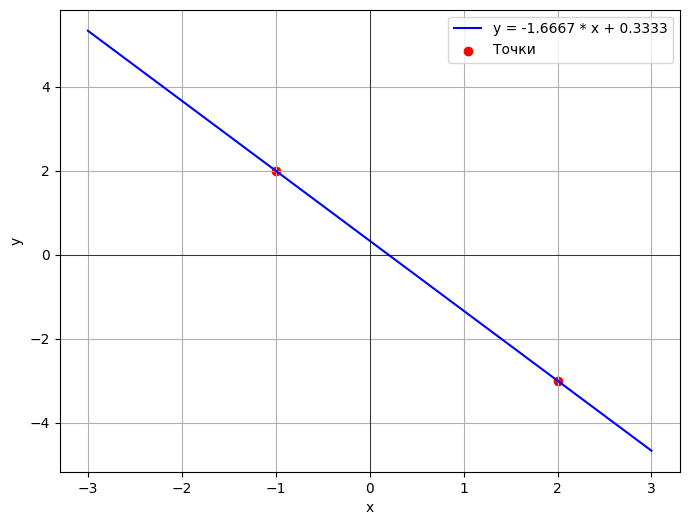

In [14]:
points = np.array([(-1, 2), (2, -3)])

x_values = np.linspace(-3, 3, 100)
y_values = a * x_values + b

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=f'y = {a:.4f} * x + {b:.4f}', color='blue')
plt.scatter(points[:,0], points[:,1], color='red', label='Точки')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.grid(True)
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.show()

Параметры подобрались так, что наше математическое выражение правильно работает на наших примерах. Что мы и хотели

### Теперь давайте автоматизируем этот процесс

Нейросети представляют очень большие математические выражения.  
Давайте реализуем объект `Value`, которым будем оперировать в наших выражениях.  
Это будет аналогом `torch.tensor` в pytorch.  
Далее вместе `Value` может употребляться слово "параметр"  

У `Value` будет несколько полей.   
* `data` - числовое значение  
* `_children` - множество другиех `Value` с помощью которых было получено это значение.   
    Например если  
    ```python
    a = Value(1)
    b = Value(2)
    c = a + b
    print(c._children) # set(a, b)
    ```

  А эти параметры нужны просто для дальнейшие визуализации выражений 
* `_op` - строка в которой написано, с помощью какой операции было полученно значение. Например `"+"` или `"sigmoid"`  
* `label` - просто название переменной  

Для начала мы хотим уметь складывать и умножать `Value`

In [28]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
  
    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out

In [38]:
a = Value(-5/3, label='a')
b = Value(1/3, label='b')
x = Value(-1, label='x')
c = a * x; c.label = 'c'
y = c + b; y.label = 'y'
y

Value(data=2.0)

Тут спрятана функция, которая рисует граф операций с помощью которых было полученно какие-то `Value`. Не принципиально как она работает

In [39]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    if hasattr(n, 'grad'):
      label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad)
    else:
      label = "{ %s | data %.4f }" % (n.label, n.data)
    dot.node(name = uid, label = label, shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

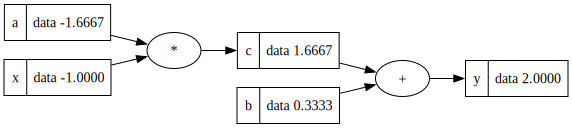

In [40]:
draw_dot(y)

Далее мы хотим для каждого `Value` посчитать по нему частную производную (чтобы, как в прошлом примере, двигать значения `Value` на размер частных производных)  
В матанализе "градиент", это вектор частных производных. В ml мы также будем называть "градиентом" значение частрой производной выражания по какому-то параметру в какой-то точке.  

Доработаем класс `Value`, чтобы считать производные  
В `self.grad` мы будем хранить значение частной производной. Изначально переменная не состоит ни в каком выражении, ни на что не влиет, поэтому поставим `self.grad = 0.0`  
Далее у нас будет функция `self._backward`, которую мы будем вызывать рекурсивно у каждого `параметра` в выражении, чтобы посчитать градиент у его `_children`, идя как бы в глубь выражения.  
```python
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
```

Предположим у нас есть выражение `F`
```
y = a * b
F = f(y)
```
Тогда `y._children = set(a, b)`   

И допустим мы уже как-то вычислили градиент `y` и он равен `y.grad`  
Мы хотим узнать градиет у значений `a` и `b`, вызвав `._backward()` у `y`. Но по началу в этот метод ничего не делает. Надо в него что-то положить.  
По логике (и правилу взятия производной сложной функции $ \frac{dF}{da} = \frac{dF}{dy} * \frac{dy}{da} $) `a.grad` должен быть равен $ \frac{dF}{dy} * \frac{dy}{da} = y.grad * b.data $. (ок, да?)  
Аналогично $ b.grad = \frac{dF}{dy} * \frac{dy}{db} = y.grad * a.data $.  
  
Давайте, при создании значения `y` через произведение `a * b` присваивать в метод `._backward` функцию, которая будет расчитывать значения градиентов у `children`, то есть у `a` и `b` в нашем случае.  
```python
class Value:
    def __mul__(self, other):
        # создаем `y` когда умножаем `a` на `b`
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad 
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out
```

В строках
```python
self.grad += other.data * out.grad 
other.grad += self.data * out.grad
```
мы делаем `+=`, а не `=`, потому что переменная/значение может встречается в выражении несколько раз.  
Например
`y = a * (a * b)`  
Тут производная по `a`, если считать на бумажке, получится  
$ \frac{dy}{da} = 2ba $  
  
А если считать алгоритмом  
`a.grad = y.grad * (a * b).data + (a * b).grad * b.data = y.grad * (a * b).data + (y.grad * a.data) * b.data`  
Если преобразовать, то получится также, как мы и посчитали руками  
`a.grad = y.grad * 2 * b * a`  

Сначала наш алгоритм посчитает градиент из первого умножения `y = a * ...`   
А потом из второго `...(a * b)`  


In [41]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out

### Проверим как работает

In [47]:
a = Value(3, label='a')
b = Value(5, label='b')
y = a * b; y.label ='y'
# пусть `y` часть какой-то функции f(y), мы знаем градиент `y` у этой функции 
y.grad = 2.0 # предположим
y._backward()
a.grad, b.grad

(10.0, 6.0)

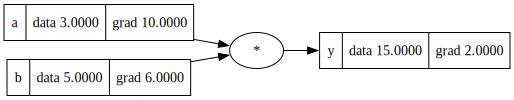

In [46]:
draw_dot(y)

Проверим на бумажке  
$ \frac{dF}{da} = \frac{dF}{dy} * \frac{dy}{da} = 2.0 * \frac{d(a * b)}{da} = 2.0 * b = 2.0 * 5 = 10 $  
  
$ \frac{dF}{db} = \frac{dF}{dy} * \frac{dy}{db} = 2.0 * \frac{d(a * b)}{db} = 2.0 * a = 2.0 * 3 = 6 $  
Все верно получилось.  


Получется, что мы должны для каждой операции, которую хотим использовать с `Value` определить, как через нее будет `течь` градиент.  
## Реализуем для сложения  
Там градиент у `children` будет такой же как у `родителя`
```py
class Value:
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
           self.grad += out.grad
           other.grad += out.grad
        out._backward = _backward
    
        return out
```

## И еще для нескольких операций
### Сделаем деление через возведение в -1ую степень

```py
class Value:
    def __pow__(self, other):
        # тут мы не хотим, чтобы other был Value, тк такая операция, где один изменяемый параметр возводится в степень другого, не используется в нейронных сетях
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other ** -1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rmul__(self, other): # other * self
        return self * other

    def __radd__(self, other): # other + self
        return self + other
```

In [53]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        
        return out

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
    
        def _backward():
           self.grad += 1.0 * out.grad
           other.grad += 1.0 * out.grad
        out._backward = _backward
    
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other ** -1

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rmul__(self, other): # other * self
        return self * other

    def __radd__(self, other): # other + self
        return self + other

## Теперь давайте посчатаем градиент сложной функции.  
Сделаем это рекурсивно для всех переменных  
Есть прикол в том, что нам надо вызывать `._backward()` только когда у родителей уже посчитан градиент.  
Чтобы понять в каком порядке делать `._backward()` отсортируем все вершины, чтобы родители были в списке раньше их детей. Это можно сделать с помощью топологической сортировки 


In [54]:
def backward(self):
    topo = []
    visited = set()
    def build_topo(v):  # топологическая сортировка
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo): # посчитаем градиент во всех вершинах
        node._backward()

Value.backward = backward

### Проверим как работает

Придумаем сложную функцию

$ f(x, a, b, c) = \frac{ax^2 + bx}{c} - \frac{a}{b+c} + x $  
  
Пусть:
```py
a = 1
b = 2
c = 3
x = 4
```

Давайте теперь вычислим производну по каждом параментру


1. Производная по \(a\):
\[
$ \frac{\partial f}{\partial a} = \frac{x^2}{c} -\frac{1}{b + c} = \frac{4^2}{3} -\frac{1}{2 + 3} = \frac{16}{3} -\frac{1}{5} = \frac{77}{15} \approx 5.13$
\]

2. Производная по \(b\):
\[
$ \frac{\partial f}{\partial b} = \frac{x}{c} + \frac{a}{(b + c)^2} = \frac{4}{3} + \frac{1}{(2 + 3)^2} = \frac{4}{3} + \frac{1}{25} = \frac{103}{75} \approx 1.37 $
\]

3. Производная по \(c\):
\[
$ \frac{\partial f}{\partial c} = - \frac{ax^2 + bx}{c^2} + \frac{a}{(b + c)^2} = - \frac{1 \cdot 4^2 + 2 \cdot 4}{3^2} + \frac{1}{(2 + 3)^2} = - \frac{16 + 8}{9} + \frac{1}{25} = -\frac{197}{75} \approx -2.63 $
\]

In [55]:
a = Value(1, label='a')
b = Value(2, label='b')
c = Value(3, label='c')
x = Value(4, label='x')

t1 = x ** 2; t1.label='t1'
t2 = a * t1; t2.label='t2'
t3 = b * x; t3.label='t3'
t4 = t2 + t3; t4.label='t4'
t5 = t4 / c; t5.label='t5'
t6 = b + c; t6.label='t6'
t7 = a / t6; t7.label='t7'
t8 = t5 - t7; t8.label='t8'
t9 = t8 + x; t9.label='t9'
t9

In [58]:
t9.backward()

In [ ]:
a.grad, b.grad, c.grad

Вау, получилось как мы и предполагали

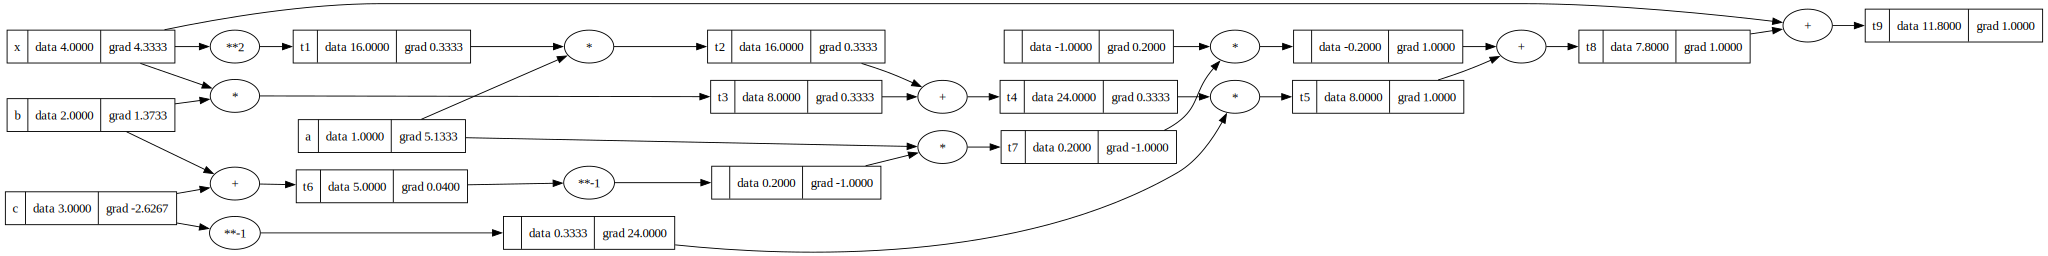

In [59]:
draw_dot(t9)

## Как это делается в pytorch

In [91]:
import torch

a = torch.FloatTensor([1])                   ; a.requires_grad = True # чтобы для переменной считался градиент, т.е чтобы она считалась изменяемым параметром
b = torch.FloatTensor([2])                   ; b.requires_grad = True
c = torch.FloatTensor([3.0])                 ; c.requires_grad = True
x = torch.FloatTensor([4])                   ; x.requires_grad = True
t9 = (a * x ** 2 + b * x) / c - a / (b + c) + x

print(t9.data.item())
t9.backward()

print('---')
print('a.grad', a.grad.item())
print('b.grad', b.grad.item())
print('c.grad', c.grad.item())

11.800000190734863
---
a.grad 5.133333683013916
b.grad 1.3733333349227905
c.grad -2.626666784286499


# Перейдем к нейросетям?

In [95]:
from setup_libs import *
import random

### Вот математическая модель нейрона мозга (перцептрон)
Он состоит из нескольких входов, весов для входов и функции "активации".  
Для каждого входа есть один вес. Каждый вход перемножается на свой вес и потом эти значения складываются.  
Результат суммы кладется в функцию активации и мы получаем выход нейрон, одно число.  
Далее мы будем соединять несколько нейроны, чтобы уже получить сеть

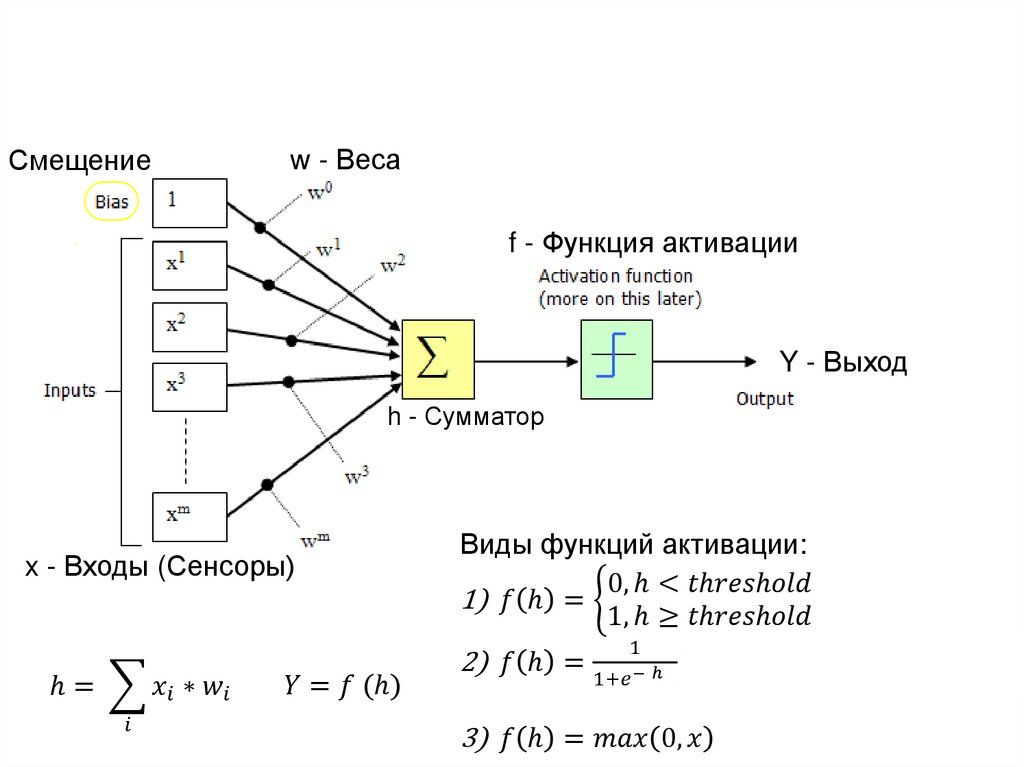

In [129]:
Image('images/perc1.png')

In [115]:
class Neuron:
    def __init__(self, nin): # `m` с картинки это `nin`
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
  
    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x))) + self.b
        out = act.sigmoid()
        return out
  
    def parameters(self):
        return self.w + [self.b]

Добавим к `Value` операцию `sigmoid` (вторая на картинке), которая используется в нейронных сетях, чтобы сделать нейрон нелинейной функцией

In [98]:
def sigmoid(self):
    out = Value(1 / (1 + math.exp(-self.data)), (self, ), 'sigmoid')

    def _backward():
        self.grad += out.data * (1 - out.data)
    out._backward = _backward
    return out


Value.sigmoid = sigmoid

In [117]:
x = [2.0, 3.0]
n = Neuron(2) # нейрон, который принимает два входа
n(x)

Value(data=0.9540828072376467)

### Нейронные сети в основном состоят из слоёв нейронов.
Слой в свою очередь состоит из нескольких нейронов.  
Вот картинка  

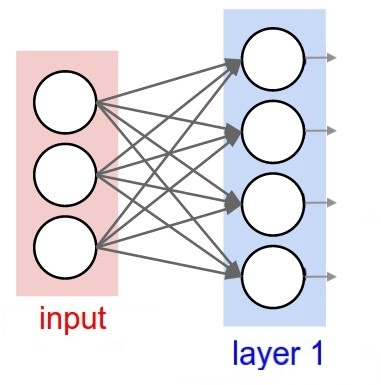

In [122]:
Image("images/layer.jpeg")

`nin` - количество входов, которые принимает слой. И одновременно сколько принимает каждый нейрон в слое  
`nout` - количество нейронов в слое. И одновременно сколько выходов у слоя (тк каждый нейрон возвращает одно значение)

In [118]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
  
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
  
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

### Теперь сделаем MLP (Multi layer perceptron)
Который уже сам по себе является нейросетью.  
Он состоит из нескольких своёв. Каждоый последующий слой принимает сколько входов, сколько выходов верных предыдущий слой

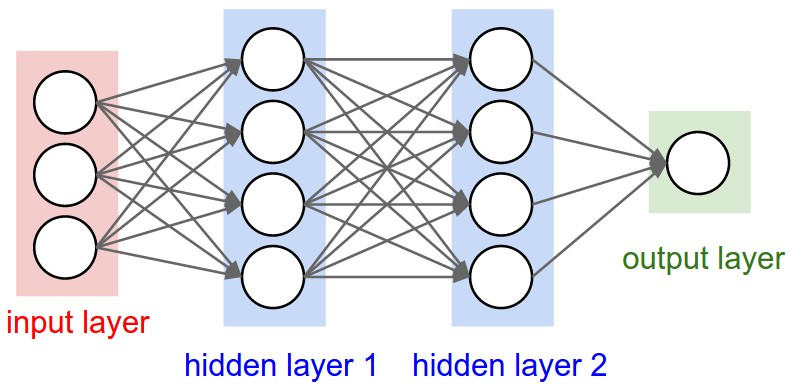

In [123]:
Image("images/mlp.png")

`nin` - количество входов, которые принимает первый слой.
`nout` - список, сколько нейронов в каждом слое

In [124]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
  
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [127]:
# реализуем картинку выше
n = MLP(3, [4, 4, 1])
x = [2, 3, 4]
n(x)

Value(data=0.48495044194002157)

# Сделать датасетик и обучиться на нем
